In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.stats.multitest as multi
import pickle

sns.set_style('white')
%matplotlib inline

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.weight'] = 'bold'

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Load in processed data from Cedars_Data_Processing.ipynb

In [3]:
df_rel_sort_list = pickle.load(open('pickle_files/rel_sort_lod_list.pkl', 'rb'))
df_abs_sort_list = pickle.load(open('pickle_files/abs_sort_lod_list.pkl', 'rb'))

df_pseudo_rel_sort_list = pickle.load(open('pickle_files/pseudo_rel_sort_lod_list.pkl', 'rb'))
df_pseudo_abs_sort_list = pickle.load(open('pickle_files/pseudo_abs_sort_lod_list.pkl', 'rb'))

df_col_names_list = pickle.load(open('pickle_files/col_names_lod_list.pkl', 'rb'))
metadata = pickle.load(open('pickle_files/metadata_all.pkl', 'rb'))

### Add metadata to sample matrix

In [4]:
for i in range(6):
    df_abs_sort_list[i] = df_abs_sort_list[i].merge(metadata, left_index=True, right_index=True)
    df_rel_sort_list[i] = df_rel_sort_list[i].merge(metadata, left_index=True, right_index=True)
    
    df_pseudo_abs_sort_list[i] = df_pseudo_abs_sort_list[i].merge(metadata, left_index=True, right_index=True)
    df_pseudo_rel_sort_list[i] = df_pseudo_rel_sort_list[i].merge(metadata, left_index=True, right_index=True)

### Compare taxa between SIBO and non-SIBO samples

In [5]:
comp = 'SIBO'
cond1 = 1
cond2 = 0

comp_exp = df_abs_sort_list[0][comp].value_counts().to_dict()

In [6]:
comp_exp

{0: 192, 1: 58}

In [7]:
df_stats_list = [None]*6

# Calculate both kruskal statistic and fisher-exact test for each comparison with benjamini-hochberg correction
for i in range(6):
    df_stats_list[i] = pd.DataFrame(columns=['Comp', 'ID', 'Group', 'Kruskal p-value', 'Abs_cond1_average', 'Abs_Cond2_average', 'Fisher p-value', 'cond1_nonzero_N', 'cond2_nonzero_N', 'total_nonzero', 'log2 Abs FC'])
    count=0
    for col in df_col_names_list[i].index.tolist():
        if (col not in df_abs_sort_list[i].columns):
            continue
        
        abs_cond1 = df_abs_sort_list[i][(df_abs_sort_list[i][comp] == cond1)][col].tolist()
        abs_cond2 = df_abs_sort_list[i][(df_abs_sort_list[i][comp] == cond2)][col].tolist()

        pseudo_abs_cond1 = np.log10(df_pseudo_abs_sort_list[i][(df_pseudo_abs_sort_list[i][comp] == cond1)][col].tolist())
        pseudo_abs_cond2 = np.log10(df_pseudo_abs_sort_list[i][(df_pseudo_abs_sort_list[i][comp] == cond2)][col].tolist())

        log2_abs_fc = np.log2(10**(np.mean(pseudo_abs_cond1)-np.mean(pseudo_abs_cond2)))
        
        nonzero_cond1 = np.count_nonzero(abs_cond1)
        nonzero_cond2 = np.count_nonzero(abs_cond2)
        
        comp_cond1 = comp_exp[cond1]
        comp_cond2 = comp_exp[cond2]
        
        if nonzero_cond1+nonzero_cond2 > 4:
            kruskal_stat, kruskal_p_value = stats.kruskal(abs_cond1, abs_cond2)
            fisher_stat, fisher_p_value = stats.fisher_exact([[nonzero_cond1, comp_cond1],[nonzero_cond2, comp_cond2]])
            df_stats_list[i].loc[count] = [str(cond1) + ' v ' + str(cond2), col, df_col_names_list[i].loc[col]['label'], kruskal_p_value, 10**np.mean(pseudo_abs_cond1), 10**np.mean(pseudo_abs_cond2), fisher_p_value, nonzero_cond1, nonzero_cond2, nonzero_cond1+nonzero_cond2, log2_abs_fc]
            count+=1

    df_stats_list[i]['fdr Kruskal p-value'] = multi.multipletests(df_stats_list[i]['Kruskal p-value'].tolist(), method='fdr_bh')[1]
    df_stats_list[i]['fdr Fisher p-value'] = multi.multipletests(df_stats_list[i]['Fisher p-value'].tolist(), method='fdr_bh')[1]
    df_stats_list[i]['-log10 Kruskal fdr'] = -np.log10(df_stats_list[i]['fdr Kruskal p-value'])
    df_stats_list[i]['-log10 Fisher fdr'] = -np.log10(df_stats_list[i]['fdr Fisher p-value'])
    df_stats_list[i]['abs log2 Abs FC'] = abs(df_stats_list[i]['log2 Abs FC'])

### Volcano plot comparing species from SIBO and non-SIBO samples

In [10]:
pal = sns.cubehelix_palette(20, rot=-.25, light=0.7)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

Text(3.6969585125463125, 0.9185089638038508, 'Lactobacillus(g)')

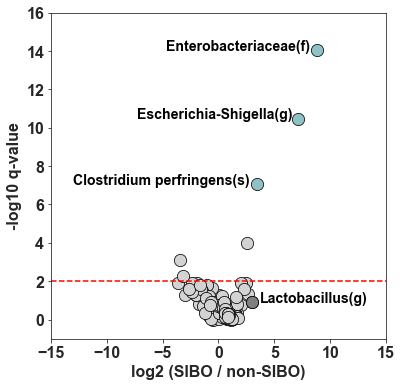

In [11]:
fig = plt.figure(figsize=(6,6))
titles = ['Species']
ax_list = []
ax_list.append(fig.add_subplot(1,1,1))

_df1 = df_stats_list[5][df_stats_list[5]['-log10 Kruskal fdr']<6]
_df2 = df_stats_list[5][df_stats_list[5]['-log10 Kruskal fdr']>6]
_df3 = df_stats_list[5].loc[82]

sns.scatterplot(ax=ax_list[0], x='log2 Abs FC', y='-log10 Kruskal fdr', data=_df1, s=150, color='lightgrey', edgecolor='k')
sns.scatterplot(ax=ax_list[0], x='log2 Abs FC', y='-log10 Kruskal fdr', data=_df2, s=150, color=pal[0], edgecolor='k')
sns.scatterplot(ax=ax_list[0], x=[df_stats_list[5].loc[84]['log2 Abs FC']], y=[df_stats_list[5].loc[84]['-log10 Kruskal fdr']], s=150, color='grey', edgecolor='k')
ax_list[0].set_ylim(-1, 16)
ax_list[0].set_xlim(-15,15)
ax_list[0].axhline(y=-np.log10(0.01), linestyle='--', color='red')

ax_list[0].set_ylabel('-log10 q-value', fontsize=16, fontweight='bold')

ax_list[0].set_xlabel('log2 (SIBO / non-SIBO)', fontsize=16, fontweight='bold')

sig_taxa = df_stats_list[5][(df_stats_list[5]['-log10 Kruskal fdr']>-np.log10(0.05))].sort_values('-log10 Kruskal fdr', ascending=False)

ax_list[0].text(sig_taxa.iloc[0]['log2 Abs FC']-13.5, sig_taxa.iloc[0]['-log10 Kruskal fdr'], sig_taxa.iloc[0]['Group'], color='k', fontsize=14)
ax_list[0].text(sig_taxa.iloc[1]['log2 Abs FC']-14.5, sig_taxa.iloc[1]['-log10 Kruskal fdr'], sig_taxa.iloc[1]['Group'], color='k', fontsize=14)
ax_list[0].text(sig_taxa.iloc[2]['log2 Abs FC']-16.5, sig_taxa.iloc[2]['-log10 Kruskal fdr'], sig_taxa.iloc[2]['Group'], color='k', fontsize=14)
ax_list[0].text(df_stats_list[5].loc[84]['log2 Abs FC']+0.7, df_stats_list[5].loc[84]['-log10 Kruskal fdr'], df_stats_list[5].loc[84]['Group'], color='k', fontsize=14)
#fig.savefig('SIBO_volcano.png', bbox_inches='tight', dpi=200)
#fig.savefig('SIBO_volcano.pdf', bbox_inches='tight', transparent=True)